In [158]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from recombinator.iid_bootstrap import iid_bootstrap
import recombinator.block_bootstrap as bb
from recombinator.optimal_block_length import optimal_block_length

from numba import njit, prange, typed, types
from numba.typed import List, Dict

import yfinance as yf 
from fredapi import Fred

import config # API keys

sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.3)

# Gathering Data

In [159]:
def getData(url, column_name):

    header = { # https://stackoverflow.com/questions/43590153/http-error-403-forbidden-when-reading-html
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
    "X-Requested-With": "XMLHttpRequest"
    }

    r = requests.get(url, headers=header)
    data = json.loads(r.text)

    data = pd.json_normalize(data, record_path=['months']) #https://towardsdatascience.com/how-to-convert-json-into-a-pandas-dataframe-100b2ae1e0d8
    data = data[['date', 'value']].apply(pd.Series)
    data['value'] = data['value'].astype(float)
    data['value'] = 1 + data['value'] / 100

    data['date'] = pd.to_datetime(data['date'], format='%Y %b')
    data = data.set_index(['date'])

    data.columns = [column_name]
    return data

In [160]:
# RPI Year on Year data
# Only care about march data for RPI so year on year

rpi_yronyr_df = getData('https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/czbh/mm23/data', 'rpi_yronyr')

# Set each month's RPI to the previous March's RPI
is_march = (rpi_yronyr_df.index.month == 3) 

first_march = False
to_drop = []
for i in range(rpi_yronyr_df.shape[0]): # Can this use itertuples() instead?
  if rpi_yronyr_df.iloc[i].name.month == 3: # If month is march
    previous_march = rpi_yronyr_df.iloc[i].values
    first_march = True
  elif not first_march: # If first march has not occurred yet.
    to_drop.append(i) # Drop outside of loop otherwise indexing will get messed up.
  else:
    rpi_yronyr_df.iloc[i] = previous_march
        
rpi_yronyr_df.drop(index = rpi_yronyr_df.index[to_drop], inplace=True)

rpi_yronyr_df

,rpi_yronyr
date,
1949-03-01,1.023
1949-04-01,1.023
1949-05-01,1.023
1949-06-01,1.023
1949-07-01,1.023
...,...
2021-09-01,1.015
2021-10-01,1.015
2021-11-01,1.015


In [161]:
# Month on Month CPI data
cpih_mnthonmnth_df = getData('https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l59c/mm23/data', 'cpih_mnthonmnth')

cpih_mnthonmnth_df

,cpih_mnthonmnth
date,
1988-02-01,1.003
1988-03-01,1.004
1988-04-01,1.013
1988-05-01,1.005
1988-06-01,1.003
...,...
2021-09-01,1.003
2021-10-01,1.009
2021-11-01,1.006


In [162]:
# SP500 Total Return data

# SP500 Total Return data in dollars (goes back further than in pounds)
SP500TR = yf.Ticker("^SP500TR").history(period = "max", interval="1mo")['Close'].to_frame()

# Fred has oldest data for exchange rate
fred = Fred(api_key=config.fredKey)
exchange = fred.get_series('EXUSUK').to_frame()
exchange.columns = ['Close']
exchange.dropna()
exchange['Close'] = 1/exchange['Close'] 

SP500TR_month_gbp = SP500TR * exchange

SP500TR_month_gbp = SP500TR_month_gbp.dropna()

# Convert to percentage change in decimal (i.e. 10% ↦ 1.10)

SP500TR_month_gbp_pct = SP500TR_month_gbp.pct_change()[1:]
SP500TR_month_gbp_pct['Close'] = SP500TR_month_gbp_pct['Close'] + 1
SP500TR_month_gbp_pct.columns = ['SP500TR_month_gbp_pct']
SP500TR_month_gbp_pct = SP500TR_month_gbp_pct.dropna()

SP500TR_month_gbp_pct

,SP500TR_month_gbp_pct
1988-03-01,0.929543
1988-04-01,0.986735
1988-05-01,1.013329
1988-06-01,1.100451
1988-07-01,1.038122
...,...
2021-09-01,0.958004
2021-10-01,1.072482
2021-11-01,1.010627
2021-12-01,1.057383


In [163]:
# Merge CPI, RPI and SP500 data into one dataframe

all_data = SP500TR_month_gbp_pct.merge(cpih_mnthonmnth_df, left_index=True, right_index=True) # merge cpi with sp500 wherever both have data for the same date.

all_data = all_data.merge(rpi_yronyr_df, left_index=True, right_index=True) #merge and use indices as the keys, equivalent to .join( , how = "inner")

all_data

,SP500TR_month_gbp_pct,cpih_mnthonmnth,rpi_yronyr
1988-03-01,0.929543,1.004,1.035
1988-04-01,0.986735,1.013,1.035
1988-05-01,1.013329,1.005,1.035
1988-06-01,1.100451,1.003,1.035
1988-07-01,1.038122,1.000,1.035
...,...,...,...
2021-09-01,0.958004,1.003,1.015
2021-10-01,1.072482,1.009,1.015
2021-11-01,1.010627,1.006,1.015
2021-12-01,1.057383,1.005,1.015


# Simulation

In [164]:
@njit()
def monthly_repayment(monthly_income, lower_taxband_monthly_income):
    delta_income = monthly_income - lower_taxband_monthly_income
    if delta_income > 0:
        return delta_income * 0.09 # 9% marginal tax on monthly income above lower taxband
    else:
        return 0

@njit()
def working_interest(monthly_income, lower_taxband_monthly_income, upper_taxband_monthly_income, rpi):
    income = monthly_income
    bottom_band = lower_taxband_monthly_income
    upper_band = upper_taxband_monthly_income

    delta_income = income - bottom_band
    if delta_income > 0:
        annual_interest_rate = rpi + 0.03 * min(delta_income / (upper_band - bottom_band), 1) # Linear interpolation with 0% at 27295 and 3% at 49130 and constant otherwise.
        # daily interest rate from annual interest rate
        return annual_interest_rate ** (1 / 365)
        # if income > upper_band:
        #     # daily interest rate from annual interest rate
        #     return (rpi + 0.03) ** (1 / 365)
        # else:
        #     # linear interpolation with 0% at 27295 and 3% at 49130 for annual interest rate
        #     return (rpi + delta_income / (upper_band - bottom_band) * 0.03) ** (1 / 365)
    else:
        return 1

In [165]:
def gen_bootstrap_samples(returns_df, bootstrap_replications, no_of_months, kind, block_length=10):
    # Generate bootstrap samples

    if kind == "iid":
        bootstrap_samples = iid_bootstrap(
            np.array(returns_df),
            replications=bootstrap_replications,
            sub_sample_length=no_of_months,
        )
    elif kind == "stationary":
        bootstrap_samples = bb.stationary_bootstrap(
            np.array(returns_df),
            block_length=block_length,
            replications=bootstrap_replications,
            sub_sample_length=no_of_months,
        )
    else:
        raise Exception(f'Unknown bootstrap type: {kind}')

    return bootstrap_samples

In [166]:
@njit()
def sim_portfolio(bootstrap_sample, lower_taxband, upper_taxband, base_yrly_salary, real_salary_yronyr_growth, real_avg_salary_yronyr_growth, daterange1, daterange2, loan_payments):
    payments = 0
    npv_payments = 0
    npv_SP500_payments = 0

    i = 0  # which month bootstrap we are on

    # only used for NPV calculation, starts when loan is first paid out unlike the previous indices which start on first job
    cpih_index = 1
    sp500_index = 1

    # income, adjusted on jan 01
    monthly_income = base_yrly_salary / 12
    lower_taxband_monthly_income = lower_taxband / 12
    upper_taxband_monthly_income = upper_taxband / 12

    # Whilst in University
    debt = 0

    for single_date in daterange1:
        if single_date[-2:] == '01' and single_date != daterange1[0]: # if first of the month
            cpih_index *= bootstrap_sample[i, 1]
            sp500_index *= bootstrap_sample[i, 0]
            i += 1

        if single_date in loan_payments:
            debt += loan_payments[single_date]

        interest = (bootstrap_sample[i, 2] + 0.03) ** (1 / 365) # bootstrap_sample[i, 2] is rpi from previous march
        debt *= interest

    # After leaving University
    for single_date in daterange2:
        if single_date[-2:] == '01': 
            cpih_index *= bootstrap_sample[i, 1]
            sp500_index *= bootstrap_sample[i, 0]
            i += 1

            if single_date[-5:-3] == '01': # if first of jan give pay raise and adjust taxbands. Should taxbands be adjusted on first on jan? Should wages be adjusted on first of jan?
                # Nominal (t) = Real (t) * Price (t)
                # Nominal (t + 1) / Nominal (t) = Real (t + 1) * Price (t + 1) / (Real (t) * Price (t))

                # real_salary_yronyr_growth = Real(t + 1) / Real (t). Real(t + 1) - Real (t) / Real(t) =  Real(t + 1) / Real(t) - 1

                # Likely not the best model for the taxbands but raising by median wage growth should be a decent model. 
                # would be better if real_salary_yronyr_growth and real_avg_salary_yronyr_growth were stochastic
                monthly_income *= real_salary_yronyr_growth * bootstrap_sample[i, 1]
                lower_taxband_monthly_income *= real_avg_salary_yronyr_growth * bootstrap_sample[i, 1] 
                upper_taxband_monthly_income *= real_avg_salary_yronyr_growth * bootstrap_sample[i, 1]

            repayment = monthly_repayment(monthly_income, lower_taxband_monthly_income)
        else:
            repayment = 0

        # interest is accrued daily whilst repayments are monthly so can't be inside previous if
        interest = working_interest(monthly_income, lower_taxband_monthly_income, upper_taxband_monthly_income, bootstrap_sample[i, 2])

        # if repayment > debt * interest
        repayment = min(repayment, debt * interest)
        debt = debt * interest - repayment # i.e. debt = 0

        payments += repayment

        npv_payments += repayment / cpih_index
        npv_SP500_payments += repayment / sp500_index

        if debt <= 0:
            break

    return [payments, npv_payments, npv_SP500_payments]

In [167]:
@njit(parallel=True)
def run_simulation_numba(bootstrap_samples, lower_taxband, upper_taxband, base_yrly_salary, real_salary_yronyr_growth, real_avg_salary_yronyr_growth, daterange1, daterange2, loan_payments):
    results = np.zeros((bootstrap_samples.shape[0], 3))

    for i in prange(bootstrap_samples.shape[0]):
        results[i] = sim_portfolio(bootstrap_samples[i], lower_taxband, upper_taxband, base_yrly_salary, real_salary_yronyr_growth, real_avg_salary_yronyr_growth, daterange1, daterange2, loan_payments)

    return results

## Parameters

In [168]:
"""
no_runs:                                    Number of simulations to perform

base_yrly_salary:                           Your yearly salary in the first year    
real_salary_yronyr_growth_relative_to_avg:  Your real wage growth compared to UK average
real_avg_salary_yronyr_growth:

lower_taxband:                              Taxband where interest starts accruing once out of university, the value should be the one for the year you left university
upper_taxband:                              Taxband where interest is at its maximum, the value should be the one for the year you left university

loan_payments:                              Each date when you receive a loan payment and the amount.

first_repayment:                            The date when you start paying back the loan
"""

no_runs = 10000

base_yrly_salary = 28000
real_salary_yronyr_growth_relative_to_avg = 0.02 # should change so its relative to avg for uni graduates

# Median income data is only available yearly till 1997 from Annual Survey of Hours and Earnings (ASHE), https://www.nomisweb.co.uk/datasets/asher? Average is monthly but only goes to 2001, https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/timeseries/eqjp/emp 
# this has from 2007 https://explore-education-statistics.service.gov.uk/find-statistics/graduate-labour-markets by education

real_avg_salary_yronyr_growth = 1.02

lower_taxband = 27295
upper_taxband = 49130

tution_loan = 9250
maintenance_loan = 4422

loan_payments = { # Update when loan payments change.
    "2021-10-05": maintenance_loan / 3,
    "2021-10-20": tution_loan / 4,
    "2022-01-18": maintenance_loan / 3,
    "2022-02-02": tution_loan / 4, 
    "2022-04-26": maintenance_loan / 3,
    "2022-05-04": tution_loan / 2,
    "2022-10-04": maintenance_loan / 3,
    "2022-10-19": tution_loan / 4, 
    "2023-01-17": maintenance_loan / 3,
    "2023-02-01": tution_loan / 4, 
    "2023-04-25": maintenance_loan / 3,
    "2023-05-03": tution_loan / 2,
    "2023-10-03": maintenance_loan / 3,
    "2023-10-18": tution_loan / 4,
    "2024-01-16": maintenance_loan / 3, 
    "2024-01-31": tution_loan / 4,
    "2024-04-24": maintenance_loan / 3, 
    "2024-05-02": tution_loan / 2,
    "2024-10-02": maintenance_loan / 3,
    "2024-10-17": tution_loan / 4, 
    "2025-01-15": maintenance_loan / 3,
    "2025-01-30": tution_loan / 4,
    "2025-04-23": maintenance_loan / 3,
    "2025-05-01": tution_loan / 2,
}

first_repayment = "2026-04-05"

In [169]:
first_payment = sorted(loan_payments)[0] # The date of the first payment from student loan company to you, also the date interest starts accruing

real_salary_yronyr_growth = real_avg_salary_yronyr_growth + real_salary_yronyr_growth_relative_to_avg

last_repayment = (pd.Timestamp(first_repayment) + pd.DateOffset(years = 30)).strftime("%Y-%m-%d") # 30 years after first repayment, 

daterange1 = [d.strftime("%Y-%m-%d") for d in pd.date_range(first_payment, first_repayment)] # converts each date into a string formatted Year - Month - Day.
daterange2 = [d.strftime("%Y-%m-%d") for d in pd.date_range((pd.Timestamp(first_repayment) + pd.DateOffset(1)).strftime("%Y-%m-%d"), last_repayment)]

daterange1_numba = List(daterange1) # numba doesn't like list of strings being passed to it, doubles in speed by this
daterange2_numba = List(daterange2)

In [170]:
# Convert dict into numba dict so it can be passed into a njited function
loan_payments_numba = Dict.empty(types.string, types.float64)

for (key, value) in loan_payments.items():
    loan_payments_numba[key] = value

# Results

In [171]:
start_date = pd.Timestamp(first_payment)
end_date = pd.Timestamp(last_repayment)
no_of_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)

# np.random.seed(0) # for testing purposes, comment out otherwise

print('Generating bootstrap sample...')
bootstrap_samples = gen_bootstrap_samples(all_data, no_runs, no_of_months, kind='stationary', block_length=36) # see end for optimal block length calculations.
# 'The block size is unfortunately a tuning parameter. The optimal stationary bootstrap block size for stocks and bonds was low, but it was over 10 years for cash-equivalent securities and inflation. Since the 'optimal' choice is calculated bas-series dependence, I expect that there's more time dependence for cash and inflation. This could be related to the business cycle or 'regime-switching' behavior documented in the macro-econometrics lit (generally linked with monetary policy regimes). Anyways, knowing the optimal blocks size is hard, but I don't think it's too big of an issue to use 10yrs when the optimal length is more than 10 for some variables. Also, if the data really was independent, block bootstraps would work (should get results similar to iid bootstrap) but they would just be less efficient.'

Generating bootstrap sample...


In [172]:
print('Simulating...')
results = run_simulation_numba(bootstrap_samples, lower_taxband, upper_taxband, base_yrly_salary, real_salary_yronyr_growth, real_avg_salary_yronyr_growth, daterange1_numba, daterange2_numba, loan_payments_numba) # first run will take longer as numba has to compile btw
# Results is a n x 3 matrix, with columns being nominal repayments, NPV of repayments wrt CPIH and NPV of repayments wrt SP500.

Simulating...


Plot...


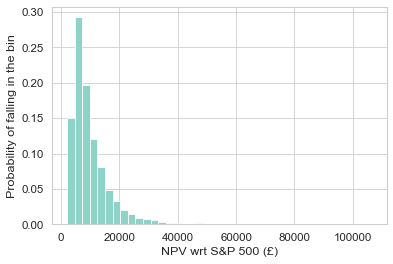

In [173]:
print('Plot...')

S = results[:, 2]
plt.hist(S, weights=np.ones_like(S) / len(S), bins=40)
plt.ylabel("Probability of falling in the bin")
plt.xlabel("NPV wrt S&P 500 (£)");

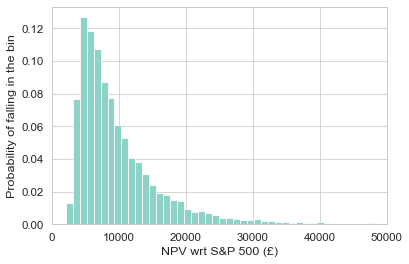

In [174]:
# X axis limited to be able to see more granular data

S = results[:, 2]
plt.hist(S, weights=np.ones_like(S) / len(S), bins=100)
plt.ylabel("Probability of falling in the bin")
plt.xlabel("NPV wrt S&P 500 (£)")
plt.xlim([0, 50000]);

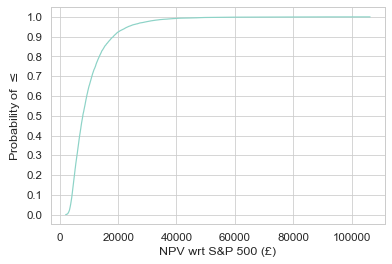

In [175]:
S = results[:, 2]

fig, ax = plt.subplots()
ax.plot(np.sort(S), np.linspace(1/len(S), 1, len(S)))
plt.ylabel("Probability of $\leq$")
plt.xlabel("NPV wrt S&P 500 (£)")
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1)); # Show axis ticks every 0.1

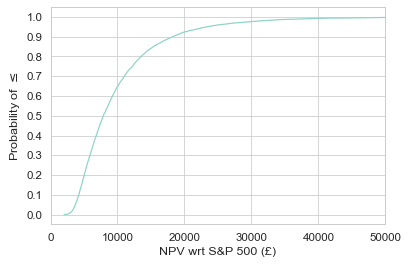

In [176]:
S = results[:, 2]

fig, ax = plt.subplots()
ax.plot(np.sort(S), np.linspace(1/len(S), 1, len(S)))
plt.ylabel("Probability of $\leq$")
plt.xlabel("NPV wrt S&P 500 (£)")
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.xlim([0, 50000]);

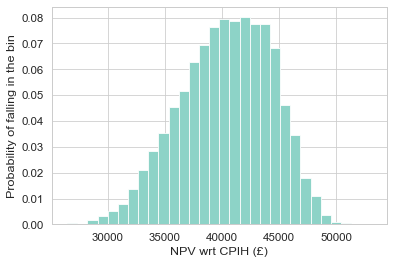

In [177]:
S = results[:, 1]

plt.hist(S, weights=np.ones_like(S) / len(S), bins=30)
plt.ylabel("Probability of falling in the bin")
plt.xlabel("NPV wrt CPIH (£)");

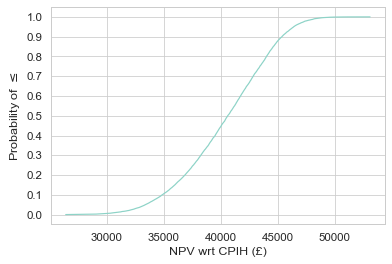

In [178]:
S = results[:, 1]

fig, ax = plt.subplots(1,1)
ax.plot(np.sort(S), np.linspace(1/len(S), 1, len(S)))
plt.ylabel("Probability of $\leq$")
plt.xlabel("NPV wrt CPIH (£)")
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1));

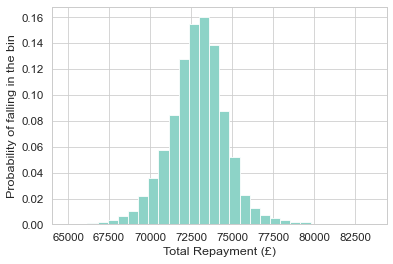

In [179]:
S = results[:, 0]
plt.hist(S, weights=np.ones_like(S) / len(S), bins=30)
plt.ylabel("Probability of falling in the bin")
plt.xlabel("Total Repayment (£)");

In [180]:
print(optimal_block_length(np.array(all_data)))

(OptimalBlockLength(b_star_sb=1.2106203199274674, b_star_cb=1.3858143225454433), OptimalBlockLength(b_star_sb=2.719305138096754, b_star_cb=3.112827321427809), OptimalBlockLength(b_star_sb=30.12902047323698, b_star_cb=34.489118849895306))


Some timing data to work out best way to parallelise code

100 runs | 1 (s) | 2 (s) | 3 (s)
--- | --- | --- | ---
jit multiprocessing pool (first 5s is setup) | 5.72 | 5.86 | 5.34
jit no pool | 6.78 | 3.08 | 3.02 | 3.03

1000 runs | 1 (s) | 2 (s) | 3 (s)
--- | --- | --- | ---
jit multiprocessing pool no gil (first 5s is setup) | 10.2 | 10.8
jit multiprocessing pool no gil everywhere (first 5s is setup) | 10.4 | 10.1 
jit multiprocessing pool (first 5s is setup) | 10.6 | 9.94 
jit njit parallel | 0.255
jit no pool | 31.1

100000 runs | 1 (s) | 2 (s) | 3 (s)
--- | --- | --- | ---
jit njit parallel | 25 | 25.1
jit njit parallel typed list | 11.3 | 11.8
jit multiprocessing pool | 543.8